https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed

In [2]:
import torch

ELBO Loss: $$ \min \mathbb{E}_q \left[ \log q\left(z\middle|x\right) - \log p\left(z\right) \right] - \mathbb{E}_q \log p\left(x\middle|z\right) $$

The first expectation is the KL divergence.

Think: the first term wants to minimize the (expected) difference between the probs given by $p$ and $q$. We're controlling $q$ here.

In [13]:
p = torch.distributions.Normal(loc=0, scale=1)
q = torch.distributions.Normal(loc=2, scale=4)

# take a sample
z = q.rsample()
print(z)

tensor(3.2009)


Given a sample from $q$, we can take the logs in the KL divergence:

In [17]:
log_pz = p.log_prob(z)
log_qzx = q.log_prob(z)

print(f"prob pz:  {torch.exp(log_pz):.4f}")
print(f"prob qzx: {torch.exp(log_qzx):.4f}")

kld = log_qzx - log_pz
print(f"kld (single point): {kld:.4f}")

prob pz:  0.0024
prob qzx: 0.0953
kld (single point): 3.6914


These are the probs of observing $z$ from the two distributions. If these two probs are vastly different for a given $x$, then if we do this over all $x$ and take the expected value, this difference will be large. Thus the KL divergence will be large.

We can move the distributions closer together and try again.

In [19]:
p = torch.distributions.Normal(loc=0, scale=1)
q = torch.distributions.Normal(loc=1, scale=2)

# plot
# ...

# take a sample
z = q.rsample()
kld = q.log_prob(z) - p.log_prob(z)
print(f"kld (single point): {kld:.4f}")

kld: 7.2369


Issue: this is technically only difference in the log probabilities for a single point $z \sim q$; what we *really* want is the **expected difference** under all possible values for $z$ (as drawn from $q$)!

In [20]:
def kl_divergence(z, mu, std):
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q = torch.distributions.Normal(mu, std)

    log_qzx = q.log_prob(z)
    log_pz = p.log_prob(z)

    kld = log_qzx - log_pz

    return kld

## My work

In [21]:
import torch

Data is $X = \left\{ x^{\left(i\right)} \right\}_{i=1}^N$, where $x$ is discrete or continuous.

Assume there is a continuous unobserved/latent rv $z$.

The data-generating process is
1. $z^{\left(i\right)} \sim p_{\theta^*}\left(z\right)$ (prior)
2. $x^{\left(i\right)} \sim p_{\theta^*}\left(x \, \middle| \, z^{\left(i\right)}\right)$ (conditional dist / likelihood).

The distributions $p_{\theta}\left(z\right)$ and $p_{\theta}\left(x \, \middle| z\right)$ are assumed to come from parametric familias of distributions. Their PDFs are differentiable a.e. w.r.t. $\theta$ and $z$ (since $z$ continuous, this is sensible).

Q: Why do they use the same variables $p$ and $\theta$? Seems confusing.

What do we want to do? Efficient and approximate:
* ML/MAP estimation of parameters $\theta$.
* posterior inference of latent variable $z$ given observed $x$, given choice of $\theta$.
* marginal inference of variable $x$ (gives us a "future" prior over $x$, to be used elsewhere).

Define $q_{\phi}\left(z \, \middle| \, x\right)$ to be "recognition model" which approximates the true posterior $p_{\theta}\left(z\,\middle|\,x\right)$. This is another parametric distribution, but we keep it very general here (rather than restrict it to be of a certain form).

The authors make the analogy of $z$ being like a latent "code" for $x$. This mapping between $x$ and $z$ is not one-to-one; rather, it is not known to us, so we can only speak of the mapping in terms of probability.

The recognition model $q_{\phi}\left(z\,\middle|\,x\right)$ is a *probabilistic encoder* since it maps an observation $x$ to a distribution of plausible values of $z$ from which $x$ could have been generated.

The model $p_{\theta}\left(x\,\middle| \, z\right)$ is a *probabilistic decoder* since it takes a "code" $z$ and produces a distribution over possible values of $x$.

Ideas:
- Write code to compute KLD between two easy dists


### 2.2 The variational bound


The marginal data likelihood is:
$$ \log p_{\theta}\left(\mathcal{D}\right) = \log p_{\theta}\left(x^{\left(i\right)}, \ldots, x^{\left(N\right)}\right) = \sum_{i=1} ^ N \log p_{\theta} \left(x^{\left(i\right)}\right) $$

We can write each term in the sum as 

$$ \log p_{\theta}\left(x^{\left(i\right)}\right) = D_{KL}\left(q_{\phi}\left(z\, \middle| \, x^{\left(i\right)}\right) \, || \, p_{\theta}\left(z\, \middle| \, x^{\left(i\right)}\right) \right) + \mathcal{L}\left(\theta, \, \phi; \, x^{\left(i\right)}\right) $$

The first term is the KL divergence of the approximation $q_{\phi}$ from the true posterior $p_{\theta}$. This is non-negative, so the sum of the two terms is always greater than the second term. Hence, the second term is called the variational lower bound on the marginal likelihood of datapoint $i$.

By simply rearranging the terms, we have
\begin{align} 
    \log p_{\theta}\left(x^{\left(i\right)}\right) & \geq \mathcal{L}\left(\theta, \phi;\, x^{\left
    (i\right)}\right) \\
\end{align}
and the variational lower bound is
\begin{align}
     \mathcal{L}\left(\theta, \phi;\, x^{\left
    (i\right)}\right) & = -D_{KL}\left(q_{\phi}\left(z\,\middle|\,x^{\left(i\right)}\right) \, || \, p_{\theta}\left(z\right)\right) + \mathbb{E}_{q_{\phi}\left(z \, \middle| \, x^{\left(i\right)}\right)} \left[ \log p_{\theta} \left(x^{\left(i\right)}\, \middle| \, z\right) \right] \\
\end{align}

Q: where does that expectation come from?

It can also be written $$ \mathcal{L}\left(\theta,\phi; \, x^{\left(i\right)}\right) = \mathbb{E}_{q_{\phi}\left(z\middle|x\right)}\left[ -\log q_{\phi}\left(z\middle|x\right) + \log p_{\theta}\left(x,z\right) \right] $$

Q: think about and explain this.

If we choose the parameters $\phi$ and $\theta$ so as to maximize $\mathcal{L}$, then we have maximized a lower bound on the marginal data likelihood; this is making the data likehood as large as possible!

It would be good to be able to take gradients of $L$ with respect to the parameters. But taking it w.r.t. $\phi$ is an issue. Why?

The "usual (naive) Monte Carlo gradient estimator" is 
\begin{align}
    \nabla_{\phi} \mathbb{E}_{q_{\phi}\left(z\right)} \left[ f\left(z\right) \right] & = \mathbb{E}_{q_{\phi}\left(z\right)} \left[ f\left(z\right) \nabla_{q_{\phi}\left(z\right)} \log q_{\phi} \left(z\right) \right] \\
    & \approx \frac{1}{L} \sum_{l=1}^L f\left(z\right) \nabla_{q_{\phi}\left(z^{\left(l\right)}\right)} \log q_{\phi}\left(z^{\left(l\right)}\right) \\
\end{align}

where $$ z^{\left(l\right)} \sim q_{\phi}\left(z\,\middle|\,x^{\left(i\right)}\right) $$ is drawn from our approximate posterior.

Q: what does this mean? Where does it come from? Should the first $z$ in the sum be $z^{\left(l\right)}$?

A: It's saying we can approximate the gradient of an expectation of $f\left(z\right)$ under a dist over $z$ by taking a bunch ($L$) of samples from the approximate posterior and computing this sum. The sum looks like an expectation value of $f\left(z\right)$, but instead of being weighted by the probability distribution, it's weighted by a gradient of the log-distribution. Need to think more about this.

The authors claim that this is a high-variance estimator, and so is bad.

### 2.3. The SGVB estimator; the AEVB algorithm

We need a better estimator of the lower bound and its gradient.

Given approximate posterior $q_{\phi}\left(z\middle|x\right)$, we want to reparam the variable $\tilde{z} \sim q_{\phi}\left(z\middle|x\right)$. Let $g_{\phi}\left(\epsilon, x\right)$ be a differentiable transformation and $\epsilon$ be a noise variable: $$ \tilde{z} = g_{\phi}\left(\epsilon, x\right), \; x\sim p\left(\epsilon\right). $$

Choosing $g$ and $p\left(\epsilon\right)$ is deferred until the next section!

With these in hand, we can compute Monte Carlo estimates of expectations:

\begin{align}
    \mathbb{E}_{q_{\phi}\left(z\middle|x^{\left(i\right)}\right)} \left[ f\left(z\right) \right] & = \mathbb{E}_{p\left(\epsilon\right)} \left[ f\left(g_{\phi}\left(\epsilon, x\right)\right) \right] \\
    & \approx \frac{1}{L} \sum_{l=1}^L f\left(g_{\phi}\left(\epsilon^{\left(l\right)}, x^{\left(i\right)}\right)\right), \; e^{\left(l\right)} \sim p\left(\epsilon\right) \\
\end{align}

Recall that the variational lower bound is written as an expectation: 
$$ \mathcal{L}\left(\theta,\phi; \, x^{\left(i\right)}\right) = \mathbb{E}_{q_{\phi}\left(z\middle|x\right)}\left[ -\log q_{\phi}\left(z\middle|x\right) + \log p_{\theta}\left(x,z\right) \right] $$

Thus we can use this Monte Carlo gradient estimator:

\begin{align}
    \tilde{\mathcal{L}}^A \left(\theta, \phi; \, x^{\left(i\right)}\right) & = \frac{1}{L}\sum_{l=1}^L \left[ \log p_{\theta} \left(x^{\left(i\right)}, z^{\left(i,l\right)}\right) - \log q_{\phi}\left(z^{\left(i,l\right)} \, \middle| \, x^{\left(i\right)}\right) \right] \\
\end{align}

where we wrote $$ z^{\left(i,l\right)} = g_{\phi}\left(\epsilon^{\left(i,l\right)}, x^{\left(i\right)}\right) \text{   and   } \epsilon^{\left(l\right)} \sim p\left(\epsilon\right) $$

### 2.4 Reparametrization Trick

Apply this trick to a Gaussian distribution
$$ z \sim p\left(z\,\middle|\,x\right) = \mathcal{N}\left(\mu,\sigma^2\right) $$

A simple (and "valid") reparametrization is 
$$ z = g\left(\epsilon, x\right) = \mu + \sigma \epsilon $$
where $$ \epsilon \sim \mathcal{N}\left(0, 1\right) $$ is an auxiliary noise var. (This is a pretty standard reparametrization; I've seen this before, e.g., in linear regression.)

Recall that we can compute the expectation of some $f\left(z\right)$ w.r.t. this reparametrization as derived in the paper:
\begin{align}
    \mathbb{E}_{q_{\phi}\left(z\middle|x^{\left(i\right)}\right)} \left[ f\left(z\right) \right] & = \mathbb{E}_{p\left(\epsilon\right)} \left[ f\left(g_{\phi}\left(\epsilon, x\right)\right) \right] \\
    & \approx \frac{1}{L} \sum_{l=1}^L f\left(g_{\phi}\left(\epsilon^{\left(l\right)}, x^{\left(i\right)}\right)\right), \; e^{\left(l\right)} \sim p\left(\epsilon\right) \\
\end{align}

\begin{align}
    \mathbb{E}_{p\left(z\,\middle|\,x\right)} \left[ f\left(z\right)\right] & = \mathbb{E}_{\mathcal{N}\left(\mu,\,\sigma^2\right)} \left[ f\left(z\right)\right] \\
    & = \mathbb{E}_{p\left(\epsilon\right)} \left[ f\left( g\left(\epsilon, x\right) \right)\right] \\
    & = \mathbb{E}_{p\left(\epsilon\right)} \left[ f\left( \mu + \epsilon \sigma \right)\right] \\
    & \approx \frac{1}{L}\sum_{l=1}^L f\left( \mu + \epsilon^{\left(l\right)}\sigma \right), \; \epsilon^{\left(l\right)} \sim p\left(\epsilon\right) \\
\end{align}

Q: where does $x$ go, here?

A: $x$ comes up in the distribution we're computing the expectation under. It's a conditioning variable, so it doesn't really play a direct role here. We have defined $p\left(z\,\middle|\,x\right) = \mathcal{N}\left(\mu,\sigma^2\right)$.

Q: How do I interpret this reparametrization?

A: We want to compute the expectation of a function under a distribution. This is a normal thing to want to do. The distribution itself may be really complex, though. If we reparametrize the distribution, we can still compute the same expectation as the expectation of a composite function over the reparametrizing distribution. Then, we can approximate the latter expectation as a sum of the function values; this is the **Monte Carlo method** for expectation calculation.

In [45]:
import torch

mu = 12.0
sigma = 2.0

# original distribution
p_z_x = torch.distributions.Normal(loc=mu, scale=sigma)

# function whose expectation we want
f = lambda z: z**2

# approximate the expectation of the original function
draws_z = p_z_x.sample(torch.Size([10_000]))
expect = f(draws_z).sum() / draws_z.shape[0]

print(f"E[f(z)] = {expect.item():.3f}")

E[f(z)] = 148.063


In [46]:
# reparametrize
p_eps = torch.distributions.Normal(loc=0.0, scale=1.0)

draws_eps = p_eps.sample(torch.Size([10_000]))
expect = f(mu + sigma * draws_eps).sum() / draws_eps.shape[0]

print(f"E[f(mu + eps * sigma)] = {expect.item():.3f}")

E[f(mu + eps * sigma)] = 148.517


tensor(149.6586)

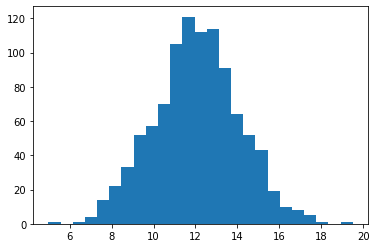

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(draws, bins=25);

## [Code!](https://github.com/HIPS/autograd/blob/master/examples/variational_autoencoder.py)